In [1]:
import warnings
warnings.filterwarnings("ignore")

### Importing Libraries

In [2]:
import spacy
import random
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from TorchCRF import CRF

### Load Dataset

In [3]:
# function to load the datatset
def load_dataset(file_path):
    sentences = []
    labels = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
        sentence = []
        
        for line in lines:
            line = line.strip() # remove leading/trailing whitespaces
            if line:
                if not line.startswith('ARG1') and not line.startswith('ARG2') and not line.startswith('REL') and not line.startswith('LOC') and not line.startswith('TIME') and not line.startswith('NONE'):
                    sentence = line
                else:
                    current_label = line
                    sentences.append(sentence)
                    labels.append(current_label)
                    
    return sentences, labels

In [4]:
# load the dataset into a pandas dataframe
sentences, labels = load_dataset('./Dataset/original_cleaned')
df = pd.DataFrame({
    'Sentence': sentences,
    'Labels': labels
})

In [5]:
df.shape

(180517, 2)

In [6]:
df

,Sentence,Labels
0,Simon is quoted as saying `` if you 'd ever se...,ARG1 REL REL ARG2 ARG2 ARG2 ARG2 ARG2 ARG2 ARG...
1,Simon is quoted as saying `` if you 'd ever se...,NONE NONE NONE NONE NONE NONE NONE NONE NONE N...
2,Simon is quoted as saying `` if you 'd ever se...,NONE NONE NONE NONE NONE NONE NONE ARG1 REL TI...
3,Simon is quoted as saying `` if you 'd ever se...,ARG1 NONE NONE REL REL NONE NONE NONE NONE NON...
4,The couple had no children .,ARG1 ARG1 REL ARG2 ARG2 NONE
...,...,...
180512,Afterwards Ong wrote : `` Hands holding Tai ch...,NONE NONE NONE NONE NONE ARG1 REL ARG2 ARG2 AR...
180513,Afterwards Ong wrote : `` Hands holding Tai ch...,NONE NONE NONE NONE NONE NONE NONE NONE NONE N...
180514,This was the time when Yang Luchan made the Ch...,ARG1 REL ARG2 ARG2 ARG2 ARG2 ARG2 ARG2 ARG2 AR...
180515,This was the time when Yang Luchan made the Ch...,NONE NONE TIME TIME NONE ARG1 ARG1 REL ARG2 AR...


In [7]:
# change this later on !!!!
df = df[:6000]

In [8]:
def remerge_sent(sent):
    # merges tokens which are not separated by white-space
    # does this recursively until no further changes
    changed = True
    while changed:
        changed = False
        i = 0
        while i < sent.__len__() - 1:
            tok = sent[i]
            if not tok.whitespace_:
                ntok = sent[i + 1]
                # in-place operation.
                with sent.retokenize() as retokenizer:
                    retokenizer.merge(sent[i: i + 2])
                changed = True
            i += 1
    return sent

In [9]:
# Tokenize sentences using spacy
nlp = spacy.load('en_core_web_sm')

In [10]:
def check_token_label_length(row):
    doc = nlp(row['Sentence'])
    spacy_sentence = remerge_sent(doc)
    tokens = [token.text for token in spacy_sentence]
    labels = row['Labels'].split()

    is_match = len(tokens) == len(labels)
    return is_match, len(tokens), len(labels), tokens

In [11]:
df[['Token_Label_Match', 'Num_Tokens', 'Num_Labels', 'Tokens']] = df.apply(check_token_label_length, axis=1, result_type="expand")

In [12]:
df.head()

,Sentence,Labels,Token_Label_Match,Num_Tokens,Num_Labels,Tokens
0,Simon is quoted as saying `` if you 'd ever se...,ARG1 REL REL ARG2 ARG2 ARG2 ARG2 ARG2 ARG2 ARG...,True,32,32,"[Simon, is, quoted, as, saying, ``, if, you, '..."
1,Simon is quoted as saying `` if you 'd ever se...,NONE NONE NONE NONE NONE NONE NONE NONE NONE N...,True,32,32,"[Simon, is, quoted, as, saying, ``, if, you, '..."
2,Simon is quoted as saying `` if you 'd ever se...,NONE NONE NONE NONE NONE NONE NONE ARG1 REL TI...,True,32,32,"[Simon, is, quoted, as, saying, ``, if, you, '..."
3,Simon is quoted as saying `` if you 'd ever se...,ARG1 NONE NONE REL REL NONE NONE NONE NONE NON...,True,32,32,"[Simon, is, quoted, as, saying, ``, if, you, '..."
4,The couple had no children .,ARG1 ARG1 REL ARG2 ARG2 NONE,True,6,6,"[The, couple, had, no, children, .]"


In [13]:
# checking rows where token and label count don't match
mismatched_rows = df[df['Token_Label_Match'] == False]
print(mismatched_rows)

Empty DataFrame
Columns: [Sentence, Labels, Token_Label_Match, Num_Tokens, Num_Labels, Tokens]
Index: []


### Generate BERT Embeddings

In [14]:
# Load the pre-trained BERT tokenizer and model
# Load the fast version of the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
bert_model = AutoModel.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)

In [15]:
# Retrieves BERT embeddings for a list of tokens using a fast tokenizer, enabling accurate aggregation of subword embeddings into their original token representations.
def get_bert_embeddings(tokens):
    inputs = tokenizer(tokens, return_tensors='pt', is_split_into_words=True, padding=False, truncation=True)

    # Get BERT embeddings from the model
    with torch.no_grad():
        outputs = bert_model(**inputs)

    # Get the embeddings for each subword
    token_embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (sequence_length, hidden_size)
    # Get word_ids to align subword tokens with the original tokens
    word_ids = inputs.word_ids()

    # Aggregate subword embeddings back to their original tokens
    aggregated_embeddings = []
    current_token_embeddings = []

    for idx, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        if len(current_token_embeddings) > 0 and word_id != word_ids[idx - 1]:
            aggregated_embeddings.append(torch.mean(torch.stack(current_token_embeddings), dim=0))
            current_token_embeddings = []
        current_token_embeddings.append(token_embeddings[idx])
    
    if len(current_token_embeddings) > 0:
        aggregated_embeddings.append(torch.mean(torch.stack(current_token_embeddings), dim=0))

    return torch.stack(aggregated_embeddings)

In [16]:
# Function to generate BERT embeddings for dataFrame
def generate_embeddings(df):
    embeddings_list = []
    for _, row in df.iterrows():
        tokenized_sentence = row['Tokens']
        embeddings = get_bert_embeddings(tokenized_sentence)
        embeddings_list.append(embeddings)
    return embeddings_list

In [17]:
embeddings_list = generate_embeddings(df)

In [18]:
# Checking the length of longest sentence embedding
max_len = max(embedding.shape[0] for embedding in embeddings_list)
print(f"The length of the longest embedding is: {max_len}")

The length of the longest embedding is: 133


In [19]:
# pad the embeddings to ensure uniformity across dataset as model will be trained in batches
padded_embeddings = pad_sequence(embeddings_list, batch_first=True)
df['Embeddings'] = [padded_embeddings[i] for i in range(padded_embeddings.shape[0])]
print(padded_embeddings.shape)

: 

: 

### Encoding the Labels

In [ ]:
# encode the labels
label_encoder = LabelEncoder()
labels_list = ['ARG1', 'ARG2', 'REL', 'TIME', 'LOC', 'NONE', 'PADDING'] # Adding a new label for padding
label_encoder.fit(labels_list)

df['Encoded_Labels'] = df['Labels'].apply(lambda x: label_encoder.transform(x.split()))

In [ ]:
# Encoded labels are of different lengths
df['Encoded_Labels']

0       [0, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...
2       [3, 3, 3, 3, 3, 3, 3, 0, 5, 6, 5, 1, 3, 3, 3, ...
3       [0, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, ...
4                                      [0, 0, 5, 1, 1, 3]
                              ...                        
4495    [0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, ...
4496    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...
4497    [3, 3, 0, 0, 0, 0, 3, 3, 5, 1, 1, 1, 1, 3, 3, ...
4498    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, ...
4499    [0, 0, 0, 5, 5, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, ...
Name: Encoded_Labels, Length: 4500, dtype: object

In [ ]:
# Function to pad labels to max length
def pad_labels(labels, max_len, padding_label):
    # Initialize a tensor with the padding label (assuming integer encoding)
    padded_labels = torch.full((max_len,), padding_label, dtype=torch.long)
    padded_labels[:len(labels)] = torch.tensor(labels, dtype=torch.long)
    return padded_labels

In [ ]:
padding_label = label_encoder.transform(['PADDING'])[0]
max_len = max(len(label) for label in df['Encoded_Labels'])

padded_labels = [pad_labels(label, max_len, padding_label) for label in df['Encoded_Labels']]
df['Padded_Labels'] = padded_labels

In [ ]:
df['Padded_Label_Length'] = df['Padded_Labels'].apply(len)
print(df[['Padded_Labels', 'Padded_Label_Length']])

                                          Padded_Labels  Padded_Label_Length
0     [tensor(0), tensor(5), tensor(5), tensor(1), t...                  133
1     [tensor(3), tensor(3), tensor(3), tensor(3), t...                  133
2     [tensor(3), tensor(3), tensor(3), tensor(3), t...                  133
3     [tensor(0), tensor(3), tensor(3), tensor(5), t...                  133
4     [tensor(0), tensor(0), tensor(5), tensor(1), t...                  133
...                                                 ...                  ...
4495  [tensor(0), tensor(0), tensor(0), tensor(0), t...                  133
4496  [tensor(3), tensor(3), tensor(3), tensor(3), t...                  133
4497  [tensor(3), tensor(3), tensor(0), tensor(0), t...                  133
4498  [tensor(3), tensor(3), tensor(3), tensor(3), t...                  133
4499  [tensor(0), tensor(0), tensor(0), tensor(5), t...                  133

[4500 rows x 2 columns]


### Train Validation Split

In [ ]:
# Split the data into training and validation sets
train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(
    df['Embeddings'].tolist(),  
    df['Padded_Labels'].tolist(),
    test_size=0.1,
    random_state=42
)

In [ ]:
train_dataset = TensorDataset(torch.stack(train_embeddings), torch.stack(train_labels))
val_dataset = TensorDataset(torch.stack(val_embeddings), torch.stack(val_labels))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

In [ ]:
label_to_idx = {label: idx for idx, label in enumerate(label_encoder.classes_)}
label_to_idx

{'ARG1': 0, 'ARG2': 1, 'LOC': 2, 'NONE': 3, 'PADDING': 4, 'REL': 5, 'TIME': 6}

In [ ]:
train_dataset[0]

(tensor([[-1.3255,  0.1155, -1.4901,  ..., -0.3899,  0.3392,  0.0792],
         [-1.1530,  0.3082, -1.2992,  ..., -0.2104,  0.2101, -0.4504],
         [-1.0365,  0.1374, -0.9404,  ..., -0.2345,  0.2453,  0.3756],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]))

### BiLSTM CRF Model

In [ ]:
class BiLSTM_CRF(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTM_CRF, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.hidden2tag = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirection
        self.crf = CRF(output_dim, batch_first=True)

    def forward(self, inputs, tags=None, mask=None):
        lstm_out, _ = self.lstm(inputs)  # Shape: (batch_size, seq_len, hidden_dim * 2)
        emissions = self.hidden2tag(lstm_out)  # Shape: (batch_size, seq_len, output_dim)

        if tags is not None:  # If tags are provided, calculate the loss
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        
        # If tags are not provided, return the predicted tags
        return self.crf.decode(emissions, mask=mask)

# Model parameters
input_dim = 768  # BERT Embedding size
hidden_dim = 256
output_dim = len(labels_list)

model = BiLSTM_CRF(input_dim, hidden_dim, output_dim)

### Training Loop

In [ ]:
lr = 0.001
num_epochs = 100

loss_fn = nn.CrossEntropyLoss(ignore_index=label_to_idx['PADDING'])
optimizer = optim.Adam(model.parameters(), lr=lr)

# List to store the average loss per epoch
epoch_losses = []

# Training the model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        inputs, labels = batch

        # Create mask for valid tokens (non-padding)
        # will set valid labels to True and padding labels to False
        mask = labels.ne(label_to_idx['PADDING'])  # Mask of shape [batch_size, seq_len]

        # Forward pass through the model to get logits
        loss = model(inputs, tags=labels, mask=mask)  #Shape: [batch_size, max_seq_len, num_classes]
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)  # Store the average loss for this epoch

    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

Epoch 1/100, Loss: 31.81383514404297
Epoch 2/100, Loss: 24.931666583549685
Epoch 3/100, Loss: 22.148541055074553
Epoch 4/100, Loss: 20.312904637034347
Epoch 5/100, Loss: 18.903634792420924
Epoch 6/100, Loss: 17.60653367856654
Epoch 7/100, Loss: 16.687392490666088
Epoch 8/100, Loss: 15.590241548491687
Epoch 9/100, Loss: 14.861351269047434
Epoch 10/100, Loss: 13.921170723147508
Epoch 11/100, Loss: 13.234940621911026
Epoch 12/100, Loss: 12.546288629857505
Epoch 13/100, Loss: 11.871304186379037
Epoch 14/100, Loss: 11.353745739634444
Epoch 15/100, Loss: 11.01014207049114
Epoch 16/100, Loss: 10.53636306669654
Epoch 17/100, Loss: 10.099806878624893
Epoch 18/100, Loss: 9.641476817247344
Epoch 19/100, Loss: 9.326816396015447
Epoch 20/100, Loss: 8.955983313118539
Epoch 21/100, Loss: 8.854211388564691
Epoch 22/100, Loss: 8.444046055398337
Epoch 23/100, Loss: 8.167143589112817
Epoch 24/100, Loss: 7.911784276729676
Epoch 25/100, Loss: 7.66554267232011
Epoch 26/100, Loss: 7.431347684162419
Epoch 27/

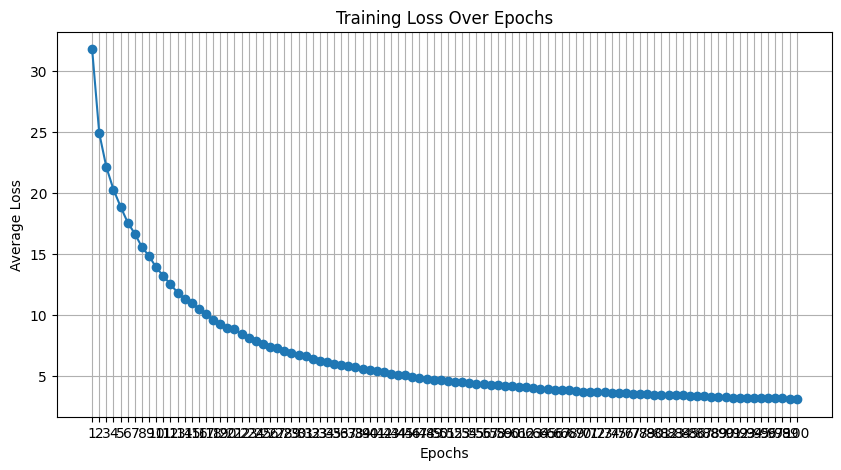

In [ ]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.grid()
plt.xticks(range(1, num_epochs + 1))  # Set x-ticks to each epoch
plt.show()

### Evaluating on Validation Data

In [ ]:
def evaluate_bilstm_crf(model, val_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    all_predicted_tags = []  # List to collect all predicted tags for analysis

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Create mask for valid tokens (non-padding)
            mask = labels.ne(label_to_idx['PADDING'])  # Mask of shape [batch_size, seq_len]

            # Forward pass through the model to get predicted tags (for CRF)
            predicted_tags = model(inputs)  # No need to pass the mask; CRF decodes the valid outputs

            # Since predicted_tags is a list of lists, convert it to a tensor for indexing
            predicted_tags = torch.tensor(predicted_tags, dtype=torch.long, device=labels.device)

            # Calculate loss only for valid tokens (masking padding labels)
            loss = model(inputs, tags=labels)  # This returns the loss with CRF
            total_loss += loss.item()

            # Mask needs to be applied on predicted_tags and labels
            correct += (predicted_tags[mask] == labels[mask]).sum().item()  # Compare valid tokens
            total += mask.sum().item()  # Count only valid tokens

    avg_loss = total_loss / len(val_loader)  # Average loss per batch
    accuracy = correct / total if total > 0 else 0  # Avoid division by zero
    print(f'Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy

In [ ]:
val_loss, val_accuracy = evaluate_bilstm_crf(model, val_loader)

Validation Loss: 439.9833, Validation Accuracy: 0.5798


### Visualizing the Text Output

In [ ]:
def evaluate_bilstm_crf_with_text_output(model, embeddings, labels):
    model.eval()
    with torch.no_grad():
        for emb, true_labels in zip(embeddings, labels):
            # Add batch dimension
            emb = emb.unsqueeze(0)  # Shape: [1, seq_length, input_dim]
            true_labels = true_labels.unsqueeze(0)  # Shape: [1, seq_length]

            # Forward pass through the model to get predictions
            # Ensure the model returns the predicted tags from CRF
            predicted_tags = model(emb)  # Get predicted labels from CRF
            
            # Since `predicted_tags` is a list of predicted sequences, you may need to convert it to a tensor
            # If you want to use just the first sequence for evaluation
            if isinstance(predicted_tags, list):
                predicted_indices = predicted_tags[0]  # Get the first sequence
            else:
                predicted_indices = predicted_tags  # Otherwise, use it directly

            # Convert predicted and true label indices to label names
            predicted_labels = label_encoder.inverse_transform(predicted_indices)  # No need for squeeze() here
            true_labels_text = label_encoder.inverse_transform(true_labels.squeeze(0).cpu().numpy())

            # Display the predicted and true labels
            print("Predicted Labels: ", predicted_labels)
            print("True Labels:      ", true_labels_text)
            print("-" * 50)

# Call the modified evaluation function
evaluate_bilstm_crf_with_text_output(model, val_embeddings, val_labels)

Predicted Labels:  ['NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE'
 'NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'NONE' 'ARG1' 'ARG1' 'NONE' 'NONE'
 'NONE' 'NONE' 'REL' 'REL' 'ARG2' 'NONE' 'REL' 'ARG2' 'ARG2' 'ARG2' 'ARG2'
 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'NONE' 'NONE'
 'NONE' 'NONE' 'NONE' 'NONE' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2'
 'ARG2' 'ARG2' 'ARG2' 'ARG1' 'ARG1' 'ARG1' 'ARG1' 'REL' 'ARG2' 'ARG2'
 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG1' 'ARG1' 'ARG1'
 'ARG1' 'REL' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2'
 'ARG1' 'ARG1' 'ARG1' 'ARG1' 'ARG1' 'REL' 'ARG2' 'ARG2' 'ARG2' 'ARG2'
 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG1' 'ARG1' 'ARG1' 'ARG1' 'REL' 'ARG2'
 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG1' 'ARG1'
 'ARG1' 'ARG1' 'REL' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2' 'ARG2'
 'ARG2' 'ARG2' 'ARG1' 'ARG1' 'ARG1' 'ARG1' 'REL' 'ARG2' 'ARG2' 'ARG2'
 'ARG2' 'ARG2']
True Labels:       ['NONE' 'NONE' 'NONE' 'NO

### CaRB Metric

In [ ]:
def load_test_dataset(file_path):

    with open(file_path, 'r', encoding='utf-8') as file:
        sentences = file.readlines()

    sentences = [sentence.strip() for sentence in sentences]
    df_test = pd.DataFrame(sentences, columns=['Sentence'])
    return df_test

df_test = load_test_dataset('./Dataset/test.txt')

In [ ]:
df_test

,Sentence
0,32.7 % of all households were made up of indiv...
1,A CEN forms an important but small part of a L...
2,"A Democrat , he became the youngest mayor in P..."
3,A cafeteria is also located on the sixth floor...
4,A casting director at the time told Scott that...
...,...
636,`` Now everything '' -- such as program tradin...
637,`` The bottom line is that if we can get that ...
638,`` The only people who are flying are those wh...
639,`` To allow this massive level of unfettered f...


In [ ]:
def generate_test_token(row):
    # Process the sentence with SpaCy
    doc = nlp(row['Sentence'])
    spacy_sentence = remerge_sent(doc)
    tokens = [token.text for token in spacy_sentence]

    return tokens

In [ ]:
df_test['Tokens'] = df_test.apply(generate_test_token, axis=1)

In [ ]:
df_test

,Sentence,Tokens
0,32.7 % of all households were made up of indiv...,"[32.7, %, of, all, households, were, made, up,..."
1,A CEN forms an important but small part of a L...,"[A, CEN, forms, an, important, but, small, par..."
2,"A Democrat , he became the youngest mayor in P...","[A, Democrat, ,, he, became, the, youngest, ma..."
3,A cafeteria is also located on the sixth floor...,"[A, cafeteria, is, also, located, on, the, six..."
4,A casting director at the time told Scott that...,"[A, casting, director, at, the, time, told, Sc..."
...,...,...
636,`` Now everything '' -- such as program tradin...,"[``, Now, everything, '', --, such, as, progra..."
637,`` The bottom line is that if we can get that ...,"[``, The, bottom, line, is, that, if, we, can,..."
638,`` The only people who are flying are those wh...,"[``, The, only, people, who, are, flying, are,..."
639,`` To allow this massive level of unfettered f...,"[``, To, allow, this, massive, level, of, unfe..."


In [ ]:
embeddings_list_test = generate_embeddings(df_test)

In [ ]:
# pad the embeddings to ensure uniformity across dataset as model will be trained in batches
padded_embeddings_test = pad_sequence(embeddings_list_test, batch_first=True)
df_test['Embeddings'] = [padded_embeddings_test[i] for i in range(padded_embeddings_test.shape[0])]
print(padded_embeddings_test.shape)

torch.Size([641, 63, 768])


### Generate Test Output

In [ ]:
# Create the reverse mapping from index to label
idx_to_label = {v: k for k, v in label_to_idx.items()}

In [ ]:
def generate_extractions_bilstm_crf(model, padded_embeddings, df_test):
    model.eval()
    
    with torch.no_grad():
        # Forward pass through the model to get predicted tags (for CRF)
        predicted_tags = model(padded_embeddings)  # No need to pass the mask; CRF decodes the valid outputs
        # Since predicted_tags is a list of lists, convert it to a tensor for indexing
        predicted_tags = torch.tensor(predicted_tags, dtype=torch.long, device=labels.device)

    results = []
    
    for i, row in df_test.iterrows():
        sentence = row['Sentence']
        tokens = row['Tokens']
        n = len(tokens)  # Number of tokens in the current sentence

        predicted_labels = predicted_tags[i][:n]
        
        # # Mask to ignore padding
        # mask = (predicted_tags[i] != label_to_idx['PADDING'])
        # predicted_labels = predicted_tags[i][mask]  # Filter out the padding predictions
        
        # Get valid tokens and their corresponding predictions
        valid_tokens = tokens[:len(predicted_labels)]
        sentence_results = []
        
        current_rel = []  # Store current relation tokens
        current_time, current_loc = '', ''  # Track TIME and LOC
        arg1_list, arg2_list = [], []  # Collect all possible ARG1 and ARG2 terms
        arg1_pos, arg2_pos, rel_pos = -1, -1, -1  # Track positions of ARG1, ARG2, REL
        
        for token_index in range(len(predicted_labels)):
            if token_index >= len(valid_tokens):
                print(f"Warning: token_index {token_index} is out of bounds for valid_tokens.")
                break  # Prevent out of range access
            
            predicted_class = predicted_labels[token_index]
            
            label = idx_to_label[predicted_class.item()]  # Convert index to label
            
            token = valid_tokens[token_index]  # Use the valid token
            
            if label == 'REL':
                current_rel.append(token)
                rel_pos = token_index
            elif label == 'ARG1':
                arg1_list.append(token)
                arg1_pos = token_index
            elif label == 'ARG2':
                arg2_list.append(token)
                arg2_pos = token_index
            elif label == 'TIME':
                current_time = token
            elif label == 'LOC':
                current_loc = token
        
        # Form relations based on different ARG1/ARG2 and REL patterns
        if current_rel:
            rel = ' '.join(current_rel)
            
            # Standard pattern: ARG1 before REL, ARG2 after REL
            if arg1_pos != -1 and arg2_pos != -1 and arg1_pos < rel_pos < arg2_pos:
                sentence_results.append(f"{sentence}\t1\t{rel}\t{' '.join(arg1_list)}\t{' '.join(arg2_list)}\t{current_time}\t{current_loc}")
            
            # Inverted pattern: ARG2 before REL, ARG1 after REL
            if arg1_pos != -1 and arg2_pos != -1 and arg2_pos < rel_pos < arg1_pos:
                sentence_results.append(f"{sentence}\t1\t{rel}\t{' '.join(arg2_list)}\t{' '.join(arg1_list)}\t{current_time}\t{current_loc}")
            
            # Both ARG1 and ARG2 before REL
            if arg1_pos != -1 and arg2_pos != -1 and arg1_pos < arg2_pos < rel_pos:
                sentence_results.append(f"{sentence}\t1\t{rel}\t{' '.join(arg1_list)}\t{' '.join(arg2_list)}\t{current_time}\t{current_loc}")
            
            # Both ARG1 and ARG2 after REL
            if arg1_pos != -1 and arg2_pos != -1 and rel_pos < arg1_pos < arg2_pos:
                sentence_results.append(f"{sentence}\t1\t{rel}\t{' '.join(arg1_list)}\t{' '.join(arg2_list)}\t{current_time}\t{current_loc}")
        
        # Check for incomplete relations (only ARG1 or ARG2 found)
        if current_rel:
            if arg1_list and not arg2_list:
                sentence_results.append(f"{sentence}\t1\t{rel}\t{' '.join(arg1_list)}\t\t{current_time}\t{current_loc}")
            elif arg2_list and not arg1_list:
                sentence_results.append(f"{sentence}\t1\t{rel}\t\t{' '.join(arg2_list)}\t{current_time}\t{current_loc}")
        
        results.extend(sentence_results)

    return results

In [ ]:
extractions = generate_extractions_bilstm_crf(model, padded_embeddings_test, df_test)

# Write output extractions to a tab separated file
with open('../CaRB/system_outputs/test/extractions.txt', 'w') as f:
    for extraction in extractions:
        f.write(extraction + '\n')

print("Test Extraction file has been created.")

Test Extraction file has been created.


In [ ]:
# TODO: 
# 1. First clean the code comments headings markdown cells, format it
# 2. Understand padding and all like how is training loop working
# 3. Plot graphs for training loss etc using matplotlib (hyperparameters)
# 4. Check the logic for CaRB labels (how to add multiple outputs)
# 5. Add CRF layer
# 6. Try adding grammar rules at last